# This notebook constitutes our project monitor

Imports and settings

In [357]:
%load_ext autoreload
%autoreload 2

import scripts.data_loader as data_loader
import scripts.data_processing as data_processing
import scripts.data_visualization as data_visualization
import scripts.time_series_modelling as time_series_modelling
import scripts.supervised_learning as supervised_learning

# Increase the number of columns displayed by pandas
import pandas as pd
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Important setting

In [358]:
#Define the window used to compute the volatility predicted
w = 10
target_vol = f'Volatility_Future_{w}_days'

#Define the window used to compute the signatures
sign_w = 10

#Ordre des signatures
sign_order = 2

#Signatures type choice
#signatures_chosen =     #signed_aires_combined  #signatures_combined #signatures

Importation of data

In [359]:
# Configuration
GOLD_SYMBOL = 'GC=F'
START_DATE = '2019-01-01'
END_DATE = '2024-10-01'

# Load or download data
gold_data_raw = data_loader.get_gold_data(GOLD_SYMBOL, START_DATE, END_DATE, refresh=False)

# Check for missing values
data_processing.missing_values_checking(gold_data_raw)

File found at: c:\Users\Luc\OneDrive\Documents\Cours\Mines (cours)\3A\Projet Indus\Features-Signatures-Volatility-Forcasting\data\gold_data.csv. 
 Loading data...

Loading data from c:\Users\Luc\OneDrive\Documents\Cours\Mines (cours)\3A\Projet Indus\Features-Signatures-Volatility-Forcasting\data\gold_data.csv...
Loaded DataFrame columns:
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
No missing values detected.


New features computation

In [360]:

# - **Log Price**: Logarithm of the "Close" price, providing a scaled and stabilized version of the closing price.
# - **Log Return**: Daily difference of Log Price, capturing daily price momentum in a log-scaled format.
# - **Moving Average (20 days)**: Rolling average of the "Close" price over 20 days, highlighting longer-term trends.
# - **Log Mid-Price**: Logarithm of the mid-price (average of "High" and "Low"), stabilizing variance and converting
#   multiplicative changes into additive ones for better analysis.
# - **Log Mid-Price Return**: Daily difference of Log Mid-Price, capturing log-scaled variations in mid-price.
# - **Spread**: Difference between "High" and "Low" prices, indicating price volatility within a time interval.
# - **Imbalance**: Relative volume difference between consecutive intervals, capturing market sentiment and activity.
# - **Volatility_Past_x_days** Volatility for windows (number of daily values used to compute) 8, 15, 21, 50, 90, 120, 260
# - **Volatility_Future_x_days** Volatility for windows (number of daily values used to compute) 8, 15, 21, 50, 90, 120, 260
gold_data_engineered = data_processing.add_metrics(gold_data_raw)

# Remove rows with any missing values, as the new features computed using past data result in the first values of these features being NaN and not computable.
gold_data_engineered_cleaned = data_processing.remove_missing_rows(gold_data_engineered)



Removed 520 rows with missing values. Indices: [Timestamp('2019-01-02 00:00:00'), Timestamp('2019-01-03 00:00:00'), Timestamp('2019-01-04 00:00:00'), Timestamp('2019-01-07 00:00:00'), Timestamp('2019-01-08 00:00:00'), Timestamp('2019-01-09 00:00:00'), Timestamp('2019-01-10 00:00:00'), Timestamp('2019-01-11 00:00:00'), Timestamp('2019-01-14 00:00:00'), Timestamp('2019-01-15 00:00:00'), Timestamp('2019-01-16 00:00:00'), Timestamp('2019-01-17 00:00:00'), Timestamp('2019-01-18 00:00:00'), Timestamp('2019-01-22 00:00:00'), Timestamp('2019-01-23 00:00:00'), Timestamp('2019-01-24 00:00:00'), Timestamp('2019-01-25 00:00:00'), Timestamp('2019-01-28 00:00:00'), Timestamp('2019-01-29 00:00:00'), Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2019-02-01 00:00:00'), Timestamp('2019-02-04 00:00:00'), Timestamp('2019-02-05 00:00:00'), Timestamp('2019-02-06 00:00:00'), Timestamp('2019-02-07 00:00:00'), Timestamp('2019-02-08 00:00:00'), Timestamp('2019-02-11 00:00:00'), 

Visualisation of the data

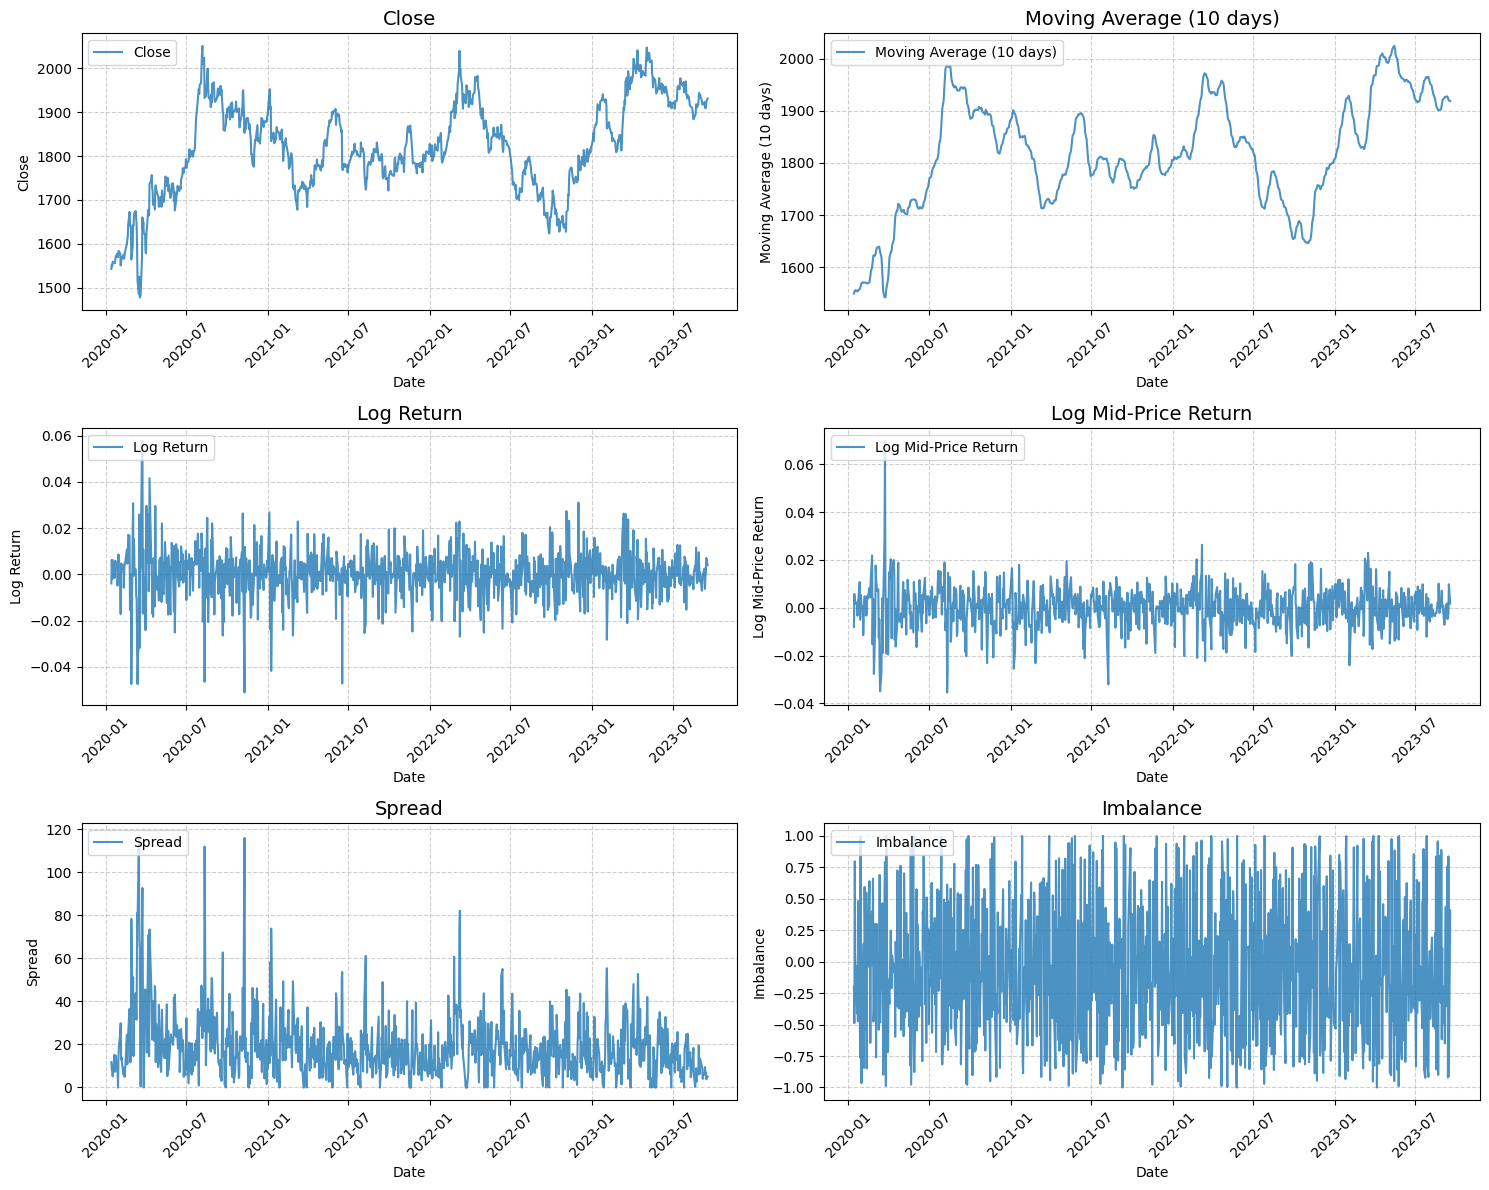

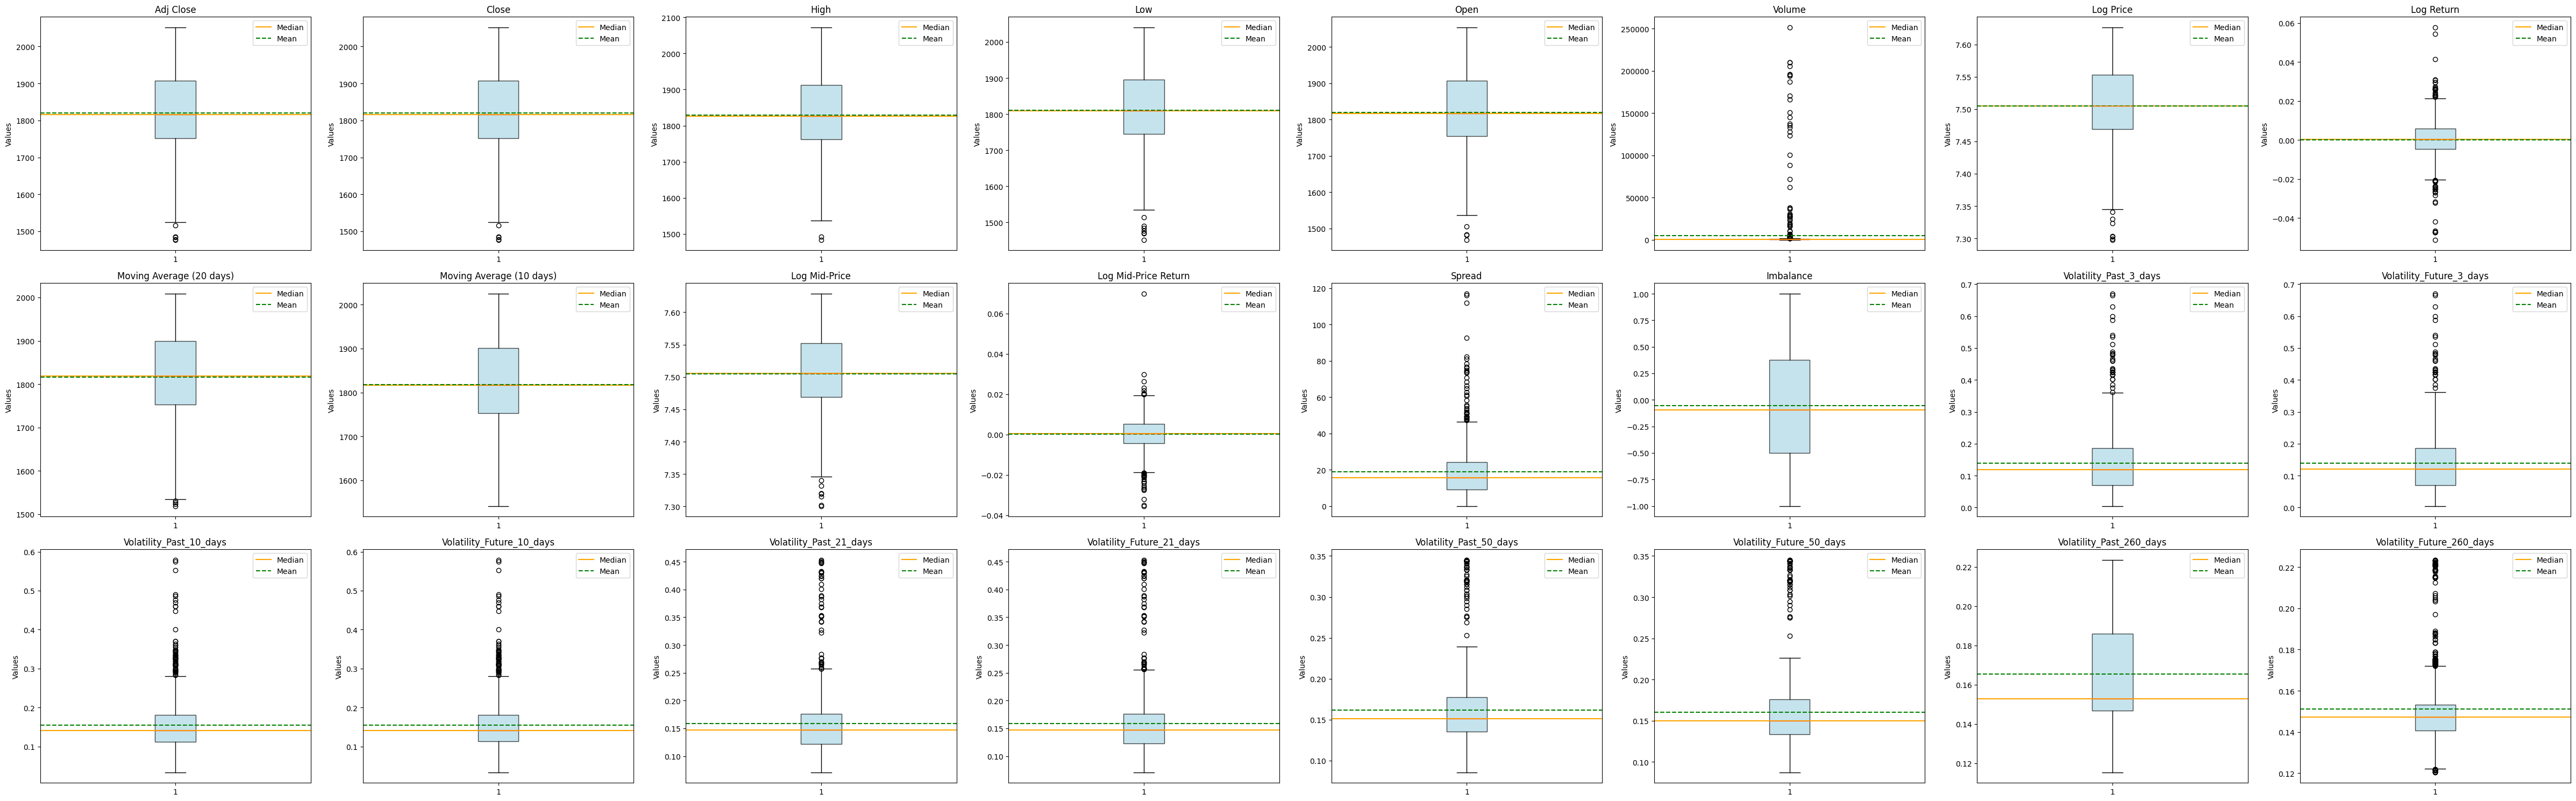

In [361]:
# Visualize all key metrics in a single multi-panel plot
data_visualization.plot_metrics(gold_data_engineered_cleaned[["Close","Moving Average (10 days)", "Log Return", "Log Mid-Price Return", "Spread", "Imbalance"]])

# Outliers identification
# Plot box plots for all numeric variables
data_visualization.plot_boxplots(gold_data_engineered_cleaned, plots_per_column=8)


We keep only the main features we will use for model training

In [362]:
selected_features = gold_data_engineered_cleaned[['Imbalance', 'Spread', 'Log Mid-Price Return',"Moving Average (10 days)", 'Log Return', 'Volume', 'Close', 'Volatility_Past_3_days','Volatility_Past_10_days', 'Volatility_Past_21_days', 'Volatility_Past_50_days','Volatility_Past_260_days']]
selected_target_features = gold_data_engineered_cleaned[['Volatility_Future_3_days','Volatility_Future_10_days', 'Volatility_Future_21_days', 'Volatility_Future_50_days','Volatility_Future_260_days']]

display(selected_features)

,Imbalance,Spread,Log Mid-Price Return,Moving Average (10 days),Log Return,Volume,Close,Volatility_Past_3_days,Volatility_Past_10_days,Volatility_Past_21_days,Volatility_Past_50_days,Volatility_Past_260_days
Date,,,,,,,,,,,,
2020-01-14,-0.200000,11.799927,-0.008016,1548.859998,-0.003882,32,1542.400024,0.080386,0.122961,0.095134,0.104517,0.115681
2020-01-15,-0.488372,8.300049,0.005792,1552.119995,0.006269,11,1552.099976,0.103302,0.124848,0.095243,0.105152,0.115562
2020-01-16,0.798165,7.599976,0.001644,1554.569995,-0.001999,98,1549.000000,0.085725,0.126280,0.095992,0.105304,0.115338
2020-01-17,0.048544,5.200073,0.002509,1555.530005,0.006307,108,1558.800049,0.075954,0.102140,0.096449,0.096915,0.115444
2020-01-21,-0.411765,15.199951,0.001541,1554.550012,-0.001541,45,1556.400024,0.074115,0.084620,0.096547,0.096310,0.115413
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-12,0.759036,9.500000,-0.004686,1927.360010,-0.006259,365,1911.300049,0.073095,0.080586,0.078028,0.088941,0.141818
2023-09-13,-0.921053,5.699951,-0.002247,1924.620007,-0.001152,15,1909.099976,0.070221,0.058205,0.078018,0.088966,0.141599
2023-09-14,0.836957,7.000000,-0.002750,1921.190002,0.000471,169,1910.000000,0.055754,0.051216,0.076507,0.088949,0.141456


Lead-lag computation

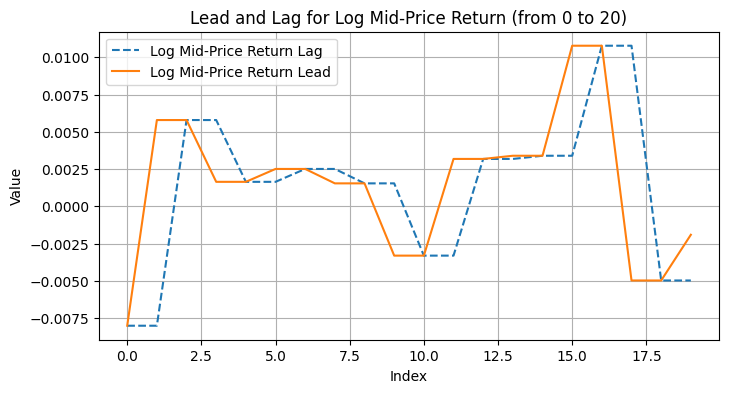

In [363]:
# Step 3: Apply lead-lag transformation
lead_lag_data = data_processing.apply_lead_lag(selected_features, lead_lag_columns=['Imbalance', 'Spread', 'Log Mid-Price Return',"Moving Average (10 days)", 'Log Return', 'Volume', 'Volatility_Past_3_days','Volatility_Past_10_days', 'Volatility_Past_21_days', 'Volatility_Past_50_days','Volatility_Past_260_days'])

# Visualize the transformed features lead-lag
data_visualization.plot_lead_lag(lead_lag_data, ["Log Mid-Price Return"])



Signatures computation

In [364]:
# Compute the signature of order 3 for the lead-lag data
signatures_raw = data_processing.compute_signature(
    selected_features,
    order=sign_order,
    windows=[sign_w],
    # exclude_cols = [] # Example: exclude the normalized time if present
)


#Compute the signed aires
signed_aires_raw = data_processing.compute_signature_differences(signatures_raw, w)

#Remove Nan rows from all datasets
signed_aires, signatures, selected_features_c, selected_target_features_c = data_processing.clean_dataframes(signed_aires_raw, signatures_raw, selected_features, selected_target_features)


Removed 9 rows with missing values.
DataFrame 1: 917 rows remaining.
DataFrame 2: 917 rows remaining.
DataFrame 3: 917 rows remaining.
DataFrame 4: 917 rows remaining.


In [365]:

# Signature computation for lead-lag dataset:
signatures_ll_raw = data_processing.compute_signature(
    lead_lag_data,
    order=sign_order,
    windows=[2*sign_w-1],
    # exclude_cols = [] # Example: exclude the normalized time if present
)

#Revert lead-Lag transfo
signatures_ll_rev_raw = data_processing.revert_lead_lag(signatures_ll_raw)

#Compute the signed aires
signed_aires_ll_raw = data_processing.compute_signature_differences(signatures_ll_rev_raw, w)

#Remove Nan rows from all datasets
signed_aires_ll, signatures_ll, selected_features_c, selected_target_features_c = data_processing.clean_dataframes(signed_aires_ll_raw, signatures_ll_rev_raw, selected_features, selected_target_features)


Removed 9 rows with missing values.
DataFrame 1: 917 rows remaining.
DataFrame 2: 917 rows remaining.
DataFrame 3: 917 rows remaining.
DataFrame 4: 917 rows remaining.


Quick visualization of the signatures

In [366]:
# data_visualization.plot_metrics(signatures_r)

Features correlation analysis

In [367]:
data_processing.rank_predictors_by_correlation(selected_target_features_c[target_vol], signatures ,signed_aires, selected_features_c)

,Predictor,Absolute Correlation
0,"sig_w10_ord2_(10,11)",0.455631
1,sig_w10_ord1_(12),0.429371
2,"sig_w10_ord2_(12,11)",0.410697
3,diff_5_7,0.408931
4,"sig_w10_ord2_(5,7)",0.400046
...,...,...
229,"sig_w10_ord2_(4,7)",0.002982
230,"sig_w10_ord2_(3,12)",0.001851
231,diff_4_11,0.001838
232,"sig_w10_ord2_(3,10)",0.001802


Adding quadratic terms

In [368]:

#Remove useless terms of signatures. There are too many to use it raw for quadratic generation
selected_signatures_1 = data_processing.get_highly_correlated_features(signatures, selected_target_features_c[target_vol], 0)

#Compute quadratic terms
signatures_quad = data_processing.get_highly_correlated_quadratics(selected_signatures_1, selected_target_features_c[target_vol], 0.03)

#We perform another features selection on selected_signatures to obtain a restricted number of features sothat the quadratic terms 
selected_signatures = data_processing.get_highly_correlated_features(selected_signatures_1, selected_target_features_c[target_vol], 0)

#Combine quadratic and normal terms
signatures_combined = pd.concat([signatures_quad, selected_signatures], axis=1)

print("signatures_combined size:", signatures_combined.shape[1])



Number of features retained: 156
Number of quadratic terms retained : 9652
Number of features retained: 156
signatures_combined size: 9808


In [369]:
# Same as the cell above just for signatures with lead-lag

#Remove useless terms of signatures. There are too many to use it raw for quadratic generation
selected_signatures_ll_1 = data_processing.get_highly_correlated_features(signatures_ll, selected_target_features_c[target_vol], 0.05)

#Compute quadratic terms
signatures_ll_quad = data_processing.get_highly_correlated_quadratics(selected_signatures_ll_1, selected_target_features_c[target_vol], 0.15)

#We perform another features selection on selected_signatures to obtain a restricted number of features sothat the quadratic terms 
selected_signatures_ll = data_processing.get_highly_correlated_features(selected_signatures_ll_1, selected_target_features_c[target_vol], 0)

#Combine quadratic and normal terms
signatures_ll_combined = pd.concat([signatures_ll_quad, selected_signatures_ll], axis=1)

print("signatures_combined size:", signatures_ll_combined.shape[1])



Number of features retained: 358
Number of quadratic terms retained : 19234
Number of features retained: 358
signatures_combined size: 19592


Partial Least Squares (PLS)

Score of the least important component in X_projected_df: 0.0154


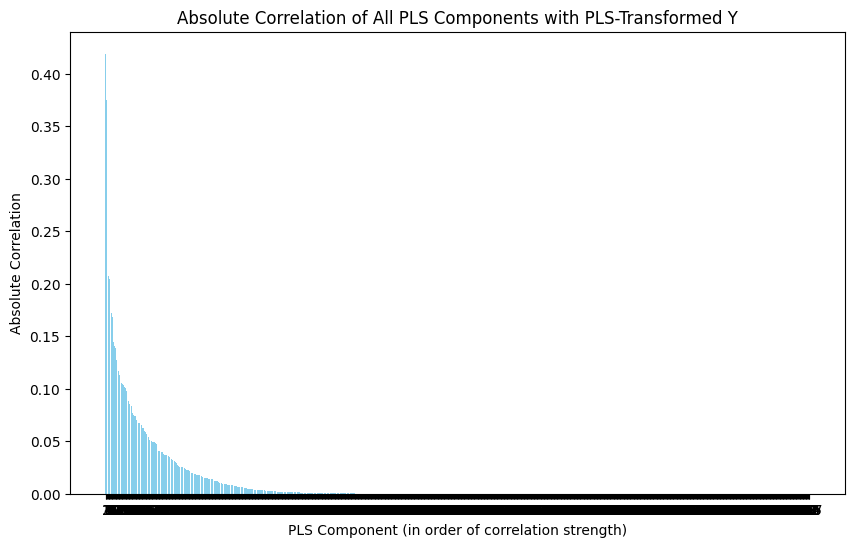

Score of the least important component in X_projected_df: 0.0132


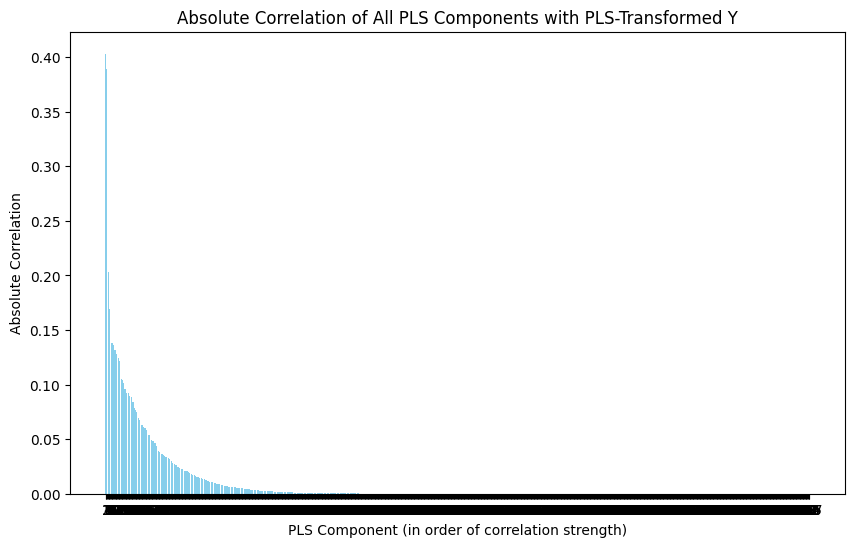

In [370]:
#Apply PLS (a normalisation is performed before as it's mandatory)
PLS_combined_signatures = supervised_learning.pls_transform_and_plot(signatures_combined, selected_target_features_c[target_vol], 130)

#Apply PLS for lead-lag transformed signatures
PLS_combined_signatures_ll = supervised_learning.pls_transform_and_plot(signatures_ll_combined, selected_target_features_c[target_vol], 130)

Time series modeling (GARCH)

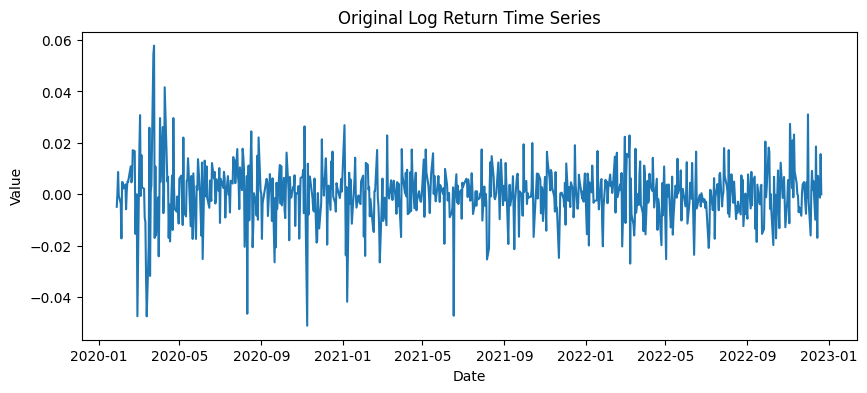

Best GARCH model: GARCH(1, 1) with BIC = -4548.34
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Log Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2284.07
Distribution:                  Normal   AIC:                          -4562.13
Method:            Maximum Likelihood   BIC:                          -4548.34
                                        No. Observations:                  733
Date:                Sun, Jan 26 2025   Df Residuals:                      733
Time:                        15:22:32   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega   

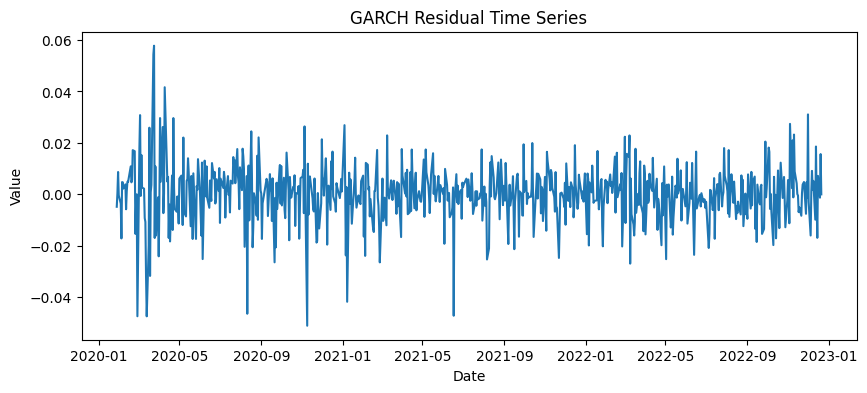

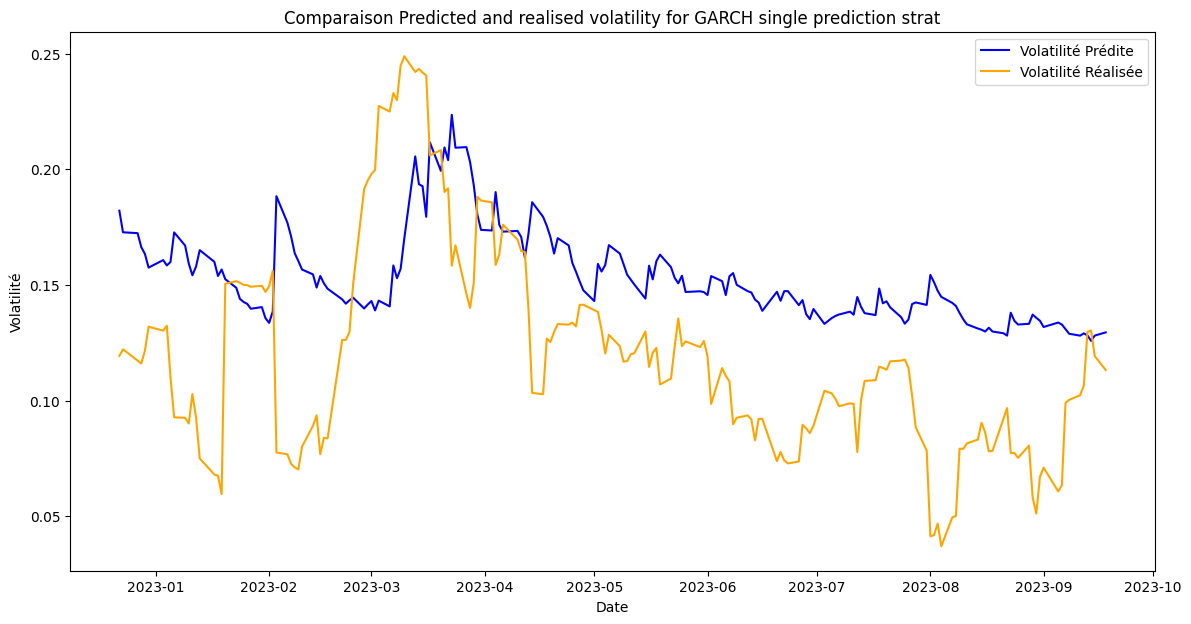

RMSE: 0.052635186585450425


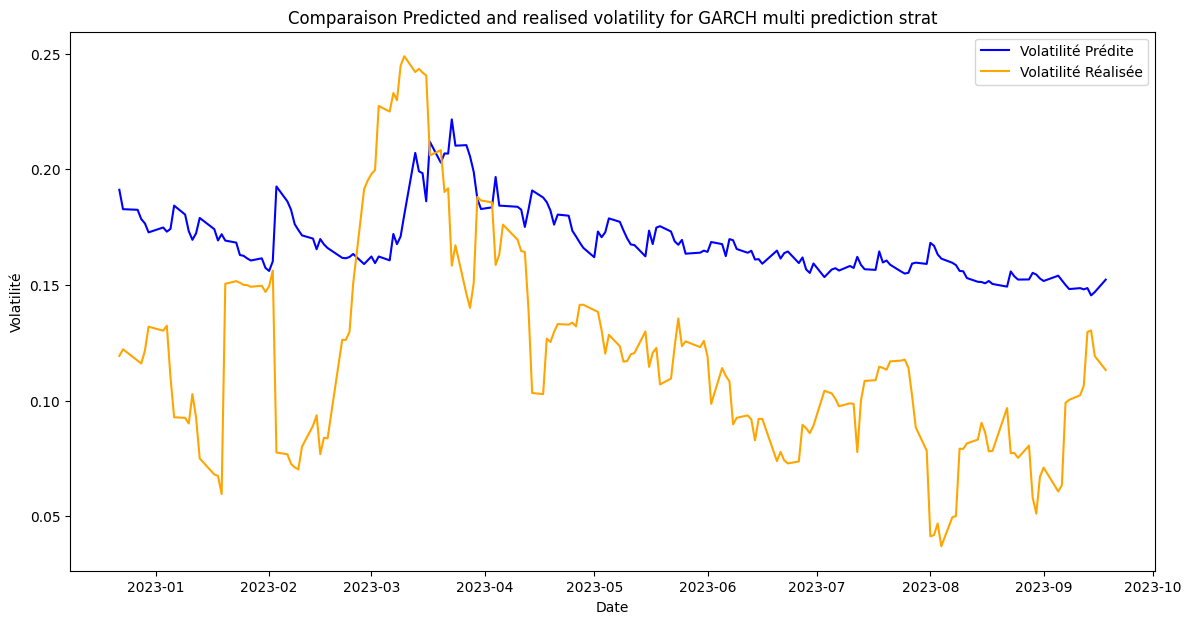

RMSE: 0.06377994246329205


In [371]:
import matplotlib.pyplot as plt

# Split the Close Price time series into train and test set
train_series, test_series, first_test_index, log_r_full_serie = data_processing.split_time_series(selected_features_c, 'Log Return', 0.2)
#Extract the target volatility
realized_vol = selected_target_features_c[target_vol]

# 1) Check stationarity for original time series
time_series_modelling.plot_series(train_series, "Original Log Return Time Series")

# 2) Differencing to make the time series stationary
# stationnary_train_ts = time_series_modelling.differentiate_ts(log_r_full_serie, diff = 1)
#time_series_modelling.plot_series(stationnary_train_ts, "1 Times differentiated time series")


# 3) Fit ARIMA 
#Plot ACP and PACF to make out which ARIMA model chosing
#time_series_modelling.plot_acf_pacf(stationnary_train_ts)
#ARIMA_model = time_series_modelling.fit_arima(train_series, 2, 1, 2)
#print(ARIMA_model.summary())
# Extract residuals from the ARIMA model
#ARIMA_residuals = ARIMA_model.resid[2:]    # We remove the two frist values which are aberrant
#time_series_modelling.plot_series(ARIMA_residuals, "ARIMA Residual Time Series")



# 4) Fit GARCH on the residuals
GARCH_model, best_p, best_q = time_series_modelling.fit_garch_auto(train_series, p_max=10, q_max=10,criterion='bic')
print(GARCH_model.summary())

# Extract residuals from the GARCH model
GARCH_residuals = GARCH_model.resid
time_series_modelling.plot_series(GARCH_residuals, "GARCH Residual Time Series")




df_predicted_vol_multi, df_realized_vol_multi = time_series_modelling.forecast_volatility_garch(
    best_p,
    best_q,
    log_r_full_serie,
    first_test_index,
    realized_vol,
    w,
    strategy = "multi"
)

df_predicted_vol_single, df_realized_vol_single = time_series_modelling.forecast_volatility_garch(
    best_p,
    best_q,
    log_r_full_serie,
    first_test_index,
    realized_vol,
    w,
    strategy = "single"
)


# Exemple d'utilisation :
# Supposons que vous avez déjà obtenu df_predicted_vol et df_realized_vol
# predicted_vol_df, realized_vol_df = forecast_volatility_garch(...)

# Appeler la fonction de traçage
time_series_modelling.plot_predicted_vs_realized_volatility(df_predicted_vol_single, df_realized_vol_single, title = 'Comparaison Predicted and realised volatility for GARCH single prediction strat')

time_series_modelling.plot_predicted_vs_realized_volatility(df_predicted_vol_multi, df_realized_vol_multi, title = 'Comparaison Predicted and realised volatility for GARCH multi prediction strat')




Data splitting for Supervised Learning

In [372]:

# We split the dataframe into a train and a test set:
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = data_processing.split_train_test(selected_features_c, PLS_combined_signatures_ll, selected_target_features_c, target_vol,  0.2, random_state = 42)


Regression models testing

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Parameters: {'regressor': ElasticNet(max_iter=1000000, random_state=42), 'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.0008} 

Model Coefficients:
         Feature  Coefficient
13    Feature_13    -0.030148
12    Feature_12    -0.029922
14    Feature_14     0.023586
15    Feature_15     0.017462
16    Feature_16     0.015298
..           ...          ...
117  Feature_117     0.000095
118  Feature_118    -0.000063
110  Feature_110    -0.000043
91    Feature_91     0.000034
123  Feature_123     0.000017

[142 rows x 2 columns]
Evaluation Metrics:
Root Mean Squared Error (RMSE): 0.0050
Mean Absolute Error (MAE): 0.0038
R² Score: 0.9876




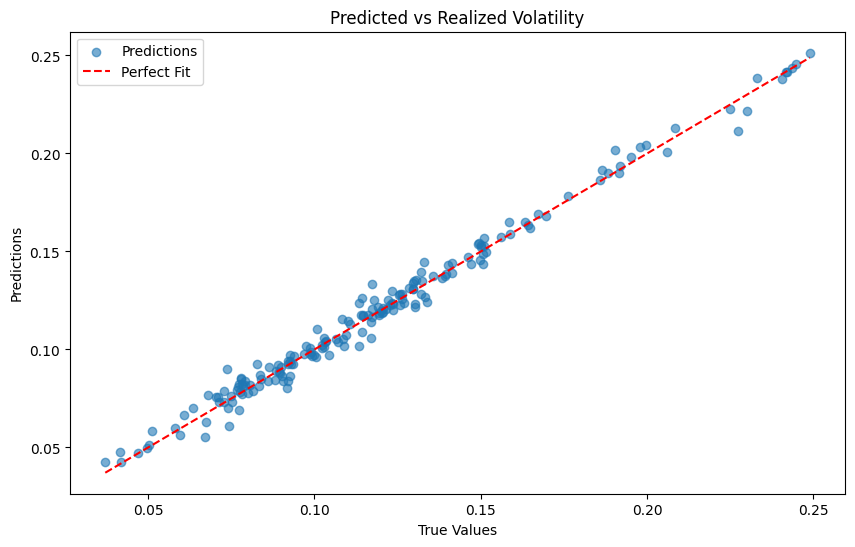

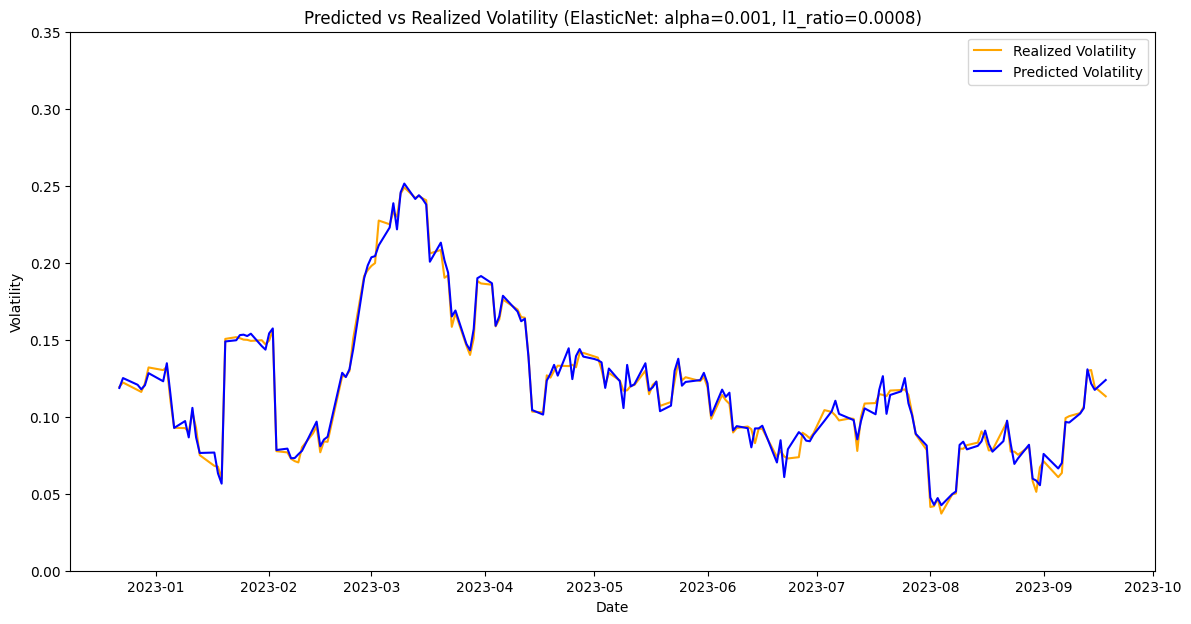

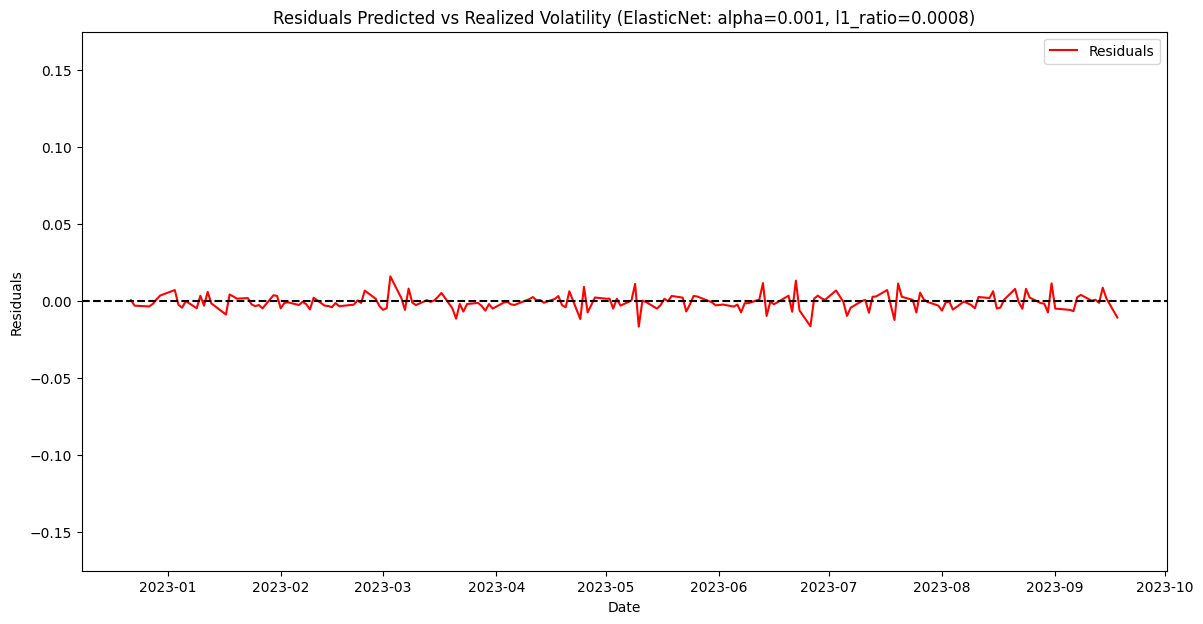

In [373]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit



# Define feature selector
feature_selector = SelectKBest(score_func=f_regression, k=10)  # Adjust 'k' as needed

# Initialize scaler
scaler = StandardScaler()

# Define models (only one should be active at a time)
# Uncomment the desired model and comment out the others

# Model 1: Lasso Regression
# model = Lasso(random_state=42, max_iter=10000)

# Model 2: Ridge Regression
# model = Ridge(random_state=42, max_iter=10000)

# Model 3: ElasticNet Regression
model = ElasticNet(random_state=42, max_iter=10000)

# Model 4: Ordinary Least Squares (Linear Regression)
# model = LinearRegression()

# Create pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    #('feature_selector', feature_selector),
    ('regressor', model)
])

# Define parameter grid for GridSearchCV
param_grid = {
    # Parameters for Lasso
    # 'regressor': [Lasso(random_state=42, max_iter=10000)],
    # 'regressor__alpha': [0.004, 0.001, 0.0008, 0.1, 0.5, 1.0, 10.0],
    
    # Uncomment below for Ridge
    # 'regressor': [Ridge(random_state=42, max_iter=10000)],
    # 'regressor__alpha': [0.05, 1.0, 1.5, 1.6, 2, 3, 2.6],
    
    # Uncomment below for ElasticNet
    'regressor': [ElasticNet(random_state=42, max_iter=1000000)],
    'regressor__alpha': [0.001, 0.008, 0.01, 0.02, 0.05, 0.007 ],
    'regressor__l1_ratio': [1e-06,1e-05, 0.0001, 0.0003, 0.0004, 0.0005, 0.0008],
    
    # Uncomment below for Linear Regression (no hyperparameters)
    # 'regressor': [LinearRegression()],
    
    # Parameters for feat selector
    # 'feature_selector__k': list(range(20, 100))
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    refit=True,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train_reg, Y_train_reg)

#Evaluate the model and display its statistics
supervised_learning.evaluate_and_plot_model(grid_search, X_test_reg, Y_test_reg, title='Predicted vs Realized Volatility')


Boosting models testing

In [388]:

# We split the dataframe into a train and a test set:
X_train_gb, X_test_gb, Y_train_gb, Y_test_gb = data_processing.split_train_test(selected_features_c, PLS_combined_signatures_ll, selected_target_features_c, target_vol,  0.2, random_state = 42)


Fitting the models...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Luc\OneDrive\Documents\Cours\Mines (cours)\3A\Projet Indus\Features-Signatures-Volatility-Forcasting\env_prov\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34737
[LightGBM] [Info] Number of data points in the train set: 733, number of used features: 142
[LightGBM] [Info] Start training from score 0.164197
Best Parameters: {'regressor': LGBMRegressor(random_state=42), 'regressor__learning_rate': 0.08, 'regressor__max_depth': -1, 'regressor__min_child_samples': 15, 'regressor__n_estimators': 300, 'regressor__num_leaves': 31} 

Evaluation Metrics:
Root Mean Squared Error (RMSE): 0.0251
Mean Absolute Error (MAE): 0.0192
R² Score: 0.6896




c:\Users\Luc\OneDrive\Documents\Cours\Mines (cours)\3A\Projet Indus\Features-Signatures-Volatility-Forcasting\env_prov\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


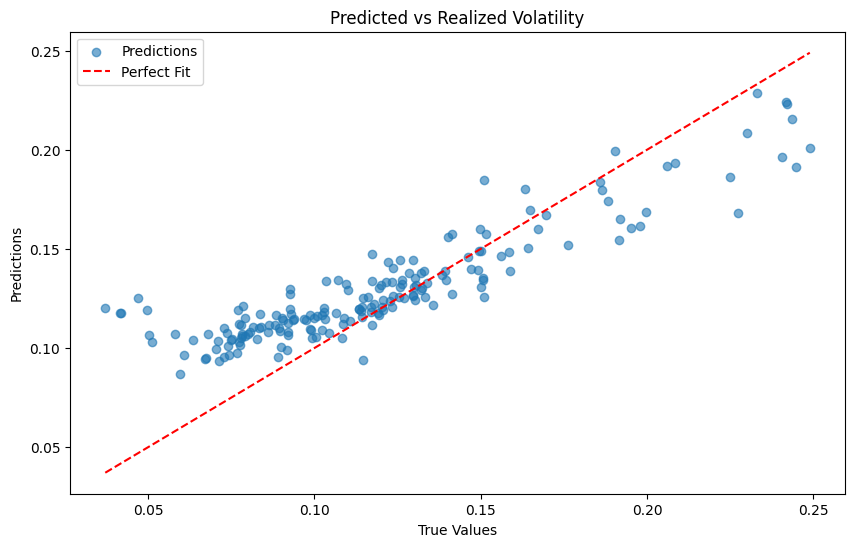

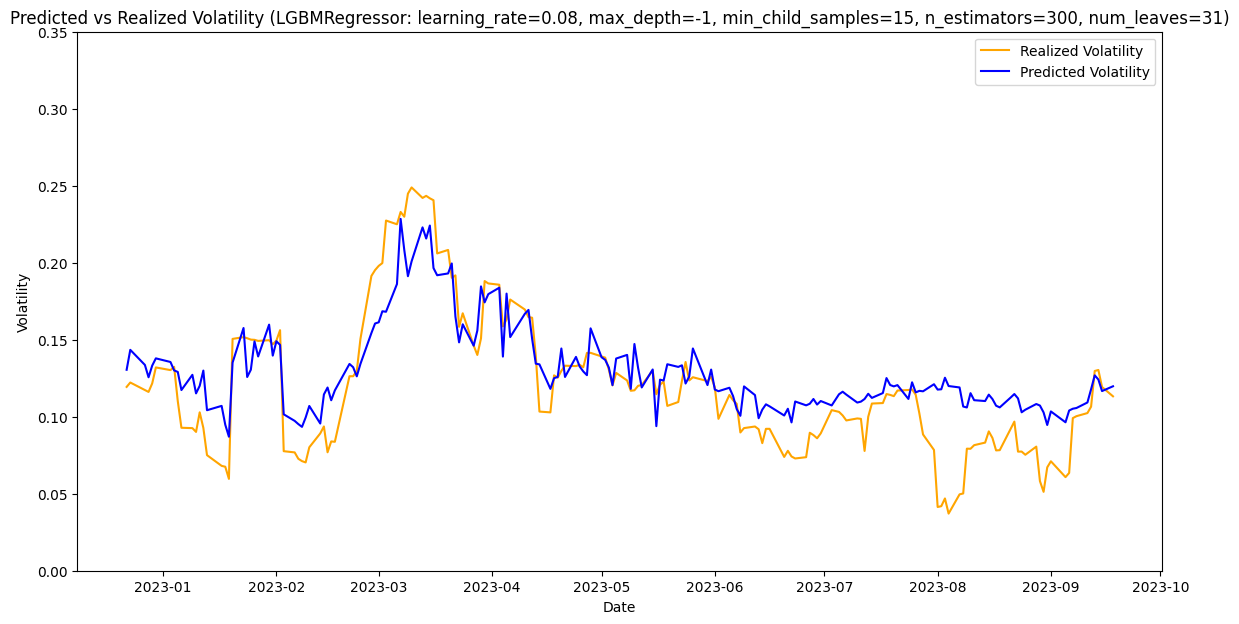

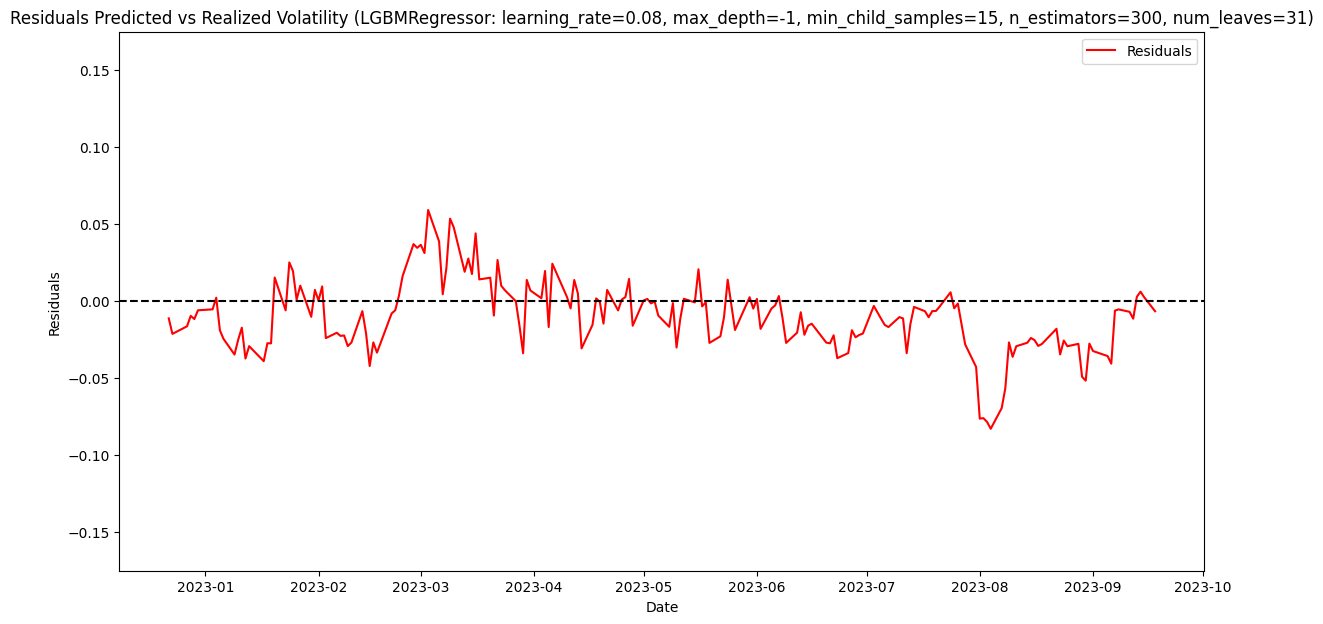

In [396]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Define the models and their hyperparameter grids
param_grid = [
    # LightGBM
    {
        'regressor': [LGBMRegressor(random_state=42)],
        'regressor__n_estimators': [300],       # Number of boosting rounds
        'regressor__learning_rate': [0.08],   # Learning rate
        'regressor__max_depth': [-1],              # Nombre maximum de feuilles qu'un arbre peut avoir
        'regressor__num_leaves': [31],           # Number of leaves per tree
        'regressor__min_child_samples':  [15],     # Minimum number of samples per leaf
        #'regressor__subsample': [0.6, 0.65],          # fraction des échantillons d'entraînement qui sont utilisés pour entraîner chaque arbre
        #'regressor__colsample_bytree': [0.8, 0.75],        # fraction des features utilisées pour entraîner chaque arbre.
    }
    # XGBoost
    #,{
    #    'regressor': [XGBRegressor(random_state=42, objective='reg:squarederror')],
    #    'regressor__n_estimators': [100],
    #    'regressor__learning_rate': [0.01, 0.1],
    #    'regressor__max_depth': [3, 7],
    #    'regressor__subsample': [0.8, 1.0],
    #    'regressor__colsample_bytree': [0.8, 1.0]
    #},
    ## Gradient Boosting (from sklearn)
    #{
    #    'regressor': [GradientBoostingRegressor(random_state=42)],
    #    'regressor__n_estimators': [100],
    #    'regressor__learning_rate': [0.01, 0.1],
    #    'regressor__max_depth': [3, 7],
    #    'regressor__min_samples_split': [2, 10],
    #    'regressor__min_samples_leaf': [1,  4]
    #}
]

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('regressor', LGBMRegressor(random_state=42))  # Placeholder; will be replaced in GridSearchCV
])

# Define TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV
grid_search_gb = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',  # Metric to evaluate the model
    refit=True,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV
print("Fitting the models...")
grid_search_gb.fit(X_train_gb, Y_train_gb)

#Evaluate the model and display its statistics
supervised_learning.evaluate_and_plot_model(grid_search_gb, X_test_gb, Y_test_gb, title='Predicted vs Realized Volatility')
